In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime

In [28]:
data = pd.read_csv('all_data_results1.csv')

In [29]:
data.head()

,pipe_dn,pipe_schedule,flange_class,length1,length2,wall_thickness,lumped_mass,raised_face_depth,w_neck_c,flange_outer_radius,flange_thickness_d,raised_face_radius,frequency,x_deformation_position,y_deformation_position,z_deformation_position,support,allowable_deformation
0,50,40,150,3064,3964,3.91,0.0,1.5,63.5,76.2,17.6,45.95,6.3338,-408.36,0.00,30.150,Fixed_Fixed,12.756
1,50,40,150,4519,4102,3.91,0.0,1.5,63.5,76.2,17.6,45.95,4.2808,243.13,0.00,30.150,Fixed_Fixed,18.440
2,50,40,150,4490,947,3.91,0.0,1.5,63.5,76.2,17.6,45.95,11.8597,1725.90,16.97,21.279,Fixed_Fixed,25.823
3,50,40,150,4134,4184,3.91,0.0,1.5,63.5,76.2,17.6,45.95,4.5764,-67.41,0.00,30.150,Fixed_Fixed,17.055
4,50,40,150,469,729,3.91,0.0,1.5,63.5,76.2,17.6,45.95,155.6812,-117.03,0.00,30.150,Fixed_Fixed,0.343


In [30]:
numeric_features = ['pipe_dn', 'flange_class', 'length1', 'length2', 'wall_thickness', 'lumped_mass',
                    'raised_face_depth', 'w_neck_c', 'flange_outer_radius', 'flange_thickness_d', 'raised_face_radius']
categorical_features = ['pipe_schedule', 'support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [31]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [32]:
target_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(target_columns, axis=1)
y = data[target_columns]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [34]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [35]:
scaler_y = StandardScaler()
y_train_transformed = scaler_y.fit_transform(y_train)
y_test_transformed = scaler_y.transform(y_test)

In [36]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [37]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(16, activation='relu')(dropout2)

# Separate output for each target variable
output_allowable_deformation = Dense(1, name='allowable_deformation')(hidden3)
output_frequency = Dense(1, name='frequency')(hidden3)
output_x_position = Dense(1, name='x_deformation_position')(hidden3)
output_y_position = Dense(1, name='y_deformation_position')(hidden3)
output_z_position = Dense(1, name='z_deformation_position')(hidden3)

In [38]:
model = Model(inputs=input_layer, outputs=[output_allowable_deformation, output_frequency, 
                                           output_x_position, output_y_position, output_z_position])

In [39]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              loss_weights=[1.0, 1.0, 1.0, 1.0, 1.0])

In [40]:
history = model.fit(
    x_train_transformed, 
    [y_train_transformed[:, i] for i in range(5)],  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - allowable_deformation_loss: 0.8810 - frequency_loss: 0.8170 - loss: 4.6019 - x_deformation_position_loss: 0.9862 - y_deformation_position_loss: 0.9193 - z_deformation_position_loss: 0.9984 - val_allowable_deformation_loss: 0.7241 - val_frequency_loss: 0.4501 - val_loss: 3.0989 - val_x_deformation_position_loss: 0.4957 - val_y_deformation_position_loss: 0.5595 - val_z_deformation_position_loss: 0.8641
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - allowable_deformation_loss: 0.7199 - frequency_loss: 0.7677 - loss: 3.5059 - x_deformation_position_loss: 0.4091 - y_deformation_position_loss: 0.7277 - z_deformation_position_loss: 0.8812 - val_allowable_deformation_loss: 0.5209 - val_frequency_loss: 0.2746 - val_loss: 2.2750 - val_x_deformation_position_loss: 0.1384 - val_y_deformation_position_loss: 0.4868 - val_z_deformation_position_loss: 0.8495
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - allowable_deformation_loss

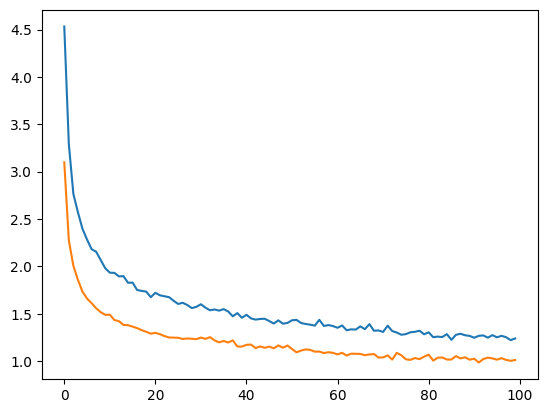

In [41]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [42]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y.inverse_transform(np.column_stack(predictions_scaled))

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
predictions_df = pd.DataFrame(predictions, columns=target_columns)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
   allowable_deformation  frequency  x_deformation_position  \
0              89.906578   3.502878            -3630.163330   
1              16.344166   8.533892             -234.565399   
2              23.906713  15.640109            -2204.944336   
3              10.424535   8.370872             -318.855316   
4              15.970489   7.195132             -289.432678   

   y_deformation_position  z_deformation_position  
0               45.803078               -0.651770  
1               -8.022782             -176.423218  
2              110.654358               -4.590275  
3                6.235110               -8.629238  
4                7.443240               28.845993  


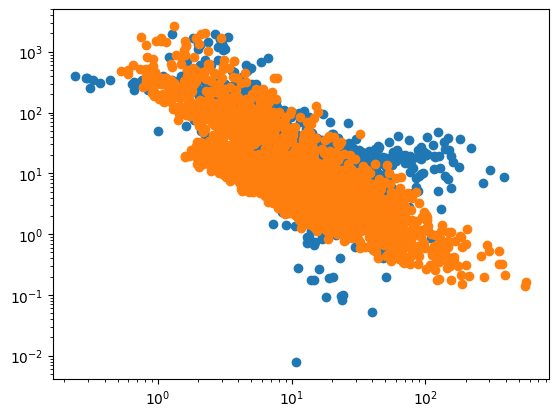

In [44]:
x=predictions_df["frequency"]
y=predictions_df["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
x=y_test["frequency"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
plt.show()

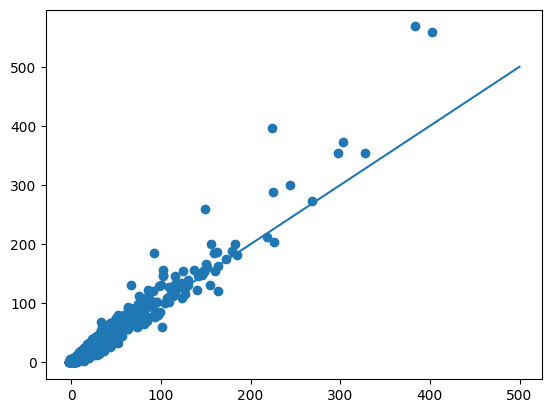

In [45]:
x=predictions_df["frequency"]
y=y_test["frequency"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 500],[0, 500])
plt.show()

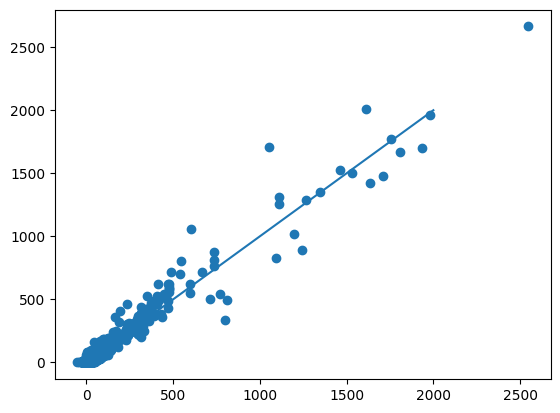

In [46]:
x=predictions_df["allowable_deformation"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 2000],[0, 2000])
plt.show()

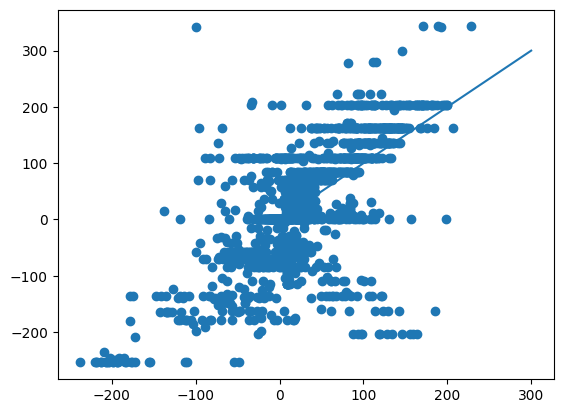

In [47]:

x=predictions_df["z_deformation_position"]
y=y_test["z_deformation_position"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 300],[0, 300])
plt.show()

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,
          2.,   5.,   6.,   9.,  16.,  40., 421.,  19.]),
 array([-1978.14452344, -1909.23827799, -1840.33203253, -1771.42578708,
        -1702.51954163, -1633.61329618, -1564.70705073, -1495.80080528,
        -1426.89455982, -1357.98831437, -1289.08206892, -1220.17582347,
        -1151.26957802, -1082.36333257, -1013.45708711,  -944.55084166,
         -875.64459621,  -806.73835076,  -737.83210531,  -668.92585986,
         -600.01961441,  -531.11336895,  -462.2071235 ,  -393.30087805,
         -324.3946326 ,  -255.48838715,  -186.5821417 ,  -117.67589624,
          -48.76965079,    20.13659466,    89.04284011]),
 <BarContainer object of 30 artists>)

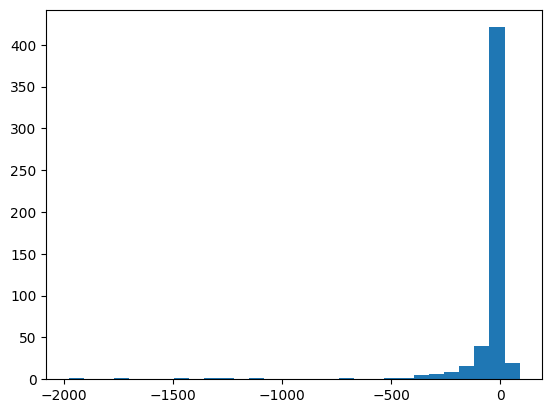

In [48]:
error= y_test["allowable_deformation"]-predictions_df["allowable_deformation"]
plt.hist(error,bins=30)

In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6008 (pid 16784), started 0:00:19 ago. (Use '!kill 16784' to kill it.)